<a href="https://colab.research.google.com/github/anuravi98/fastai-notebooks/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from fastai.vision import *

In [0]:

path_lr = Path('/content/drive/My Drive/data/bdd')
path=Path('/content/drive/My Drive/data')

path_hr=Path('/content/drive/My Drive/data/bdd_1')
path_hr.mkdir(parents=True, exist_ok=True)

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *


In [0]:
from PIL import Image, ImageDraw, ImageFont


In [0]:
def crappify(fn,i):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    w,h = img.size
    q = random.randint(10,70)
    ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
    img.save(dest, quality=q)


In [0]:
bs,size=8, 256
arch = models.resnet34


In [0]:
src = ImageImageList.from_folder(path_lr,convert_mode='L').split_by_rand_pct(0.1, seed=42)


In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data


In [0]:
data_gen = get_data(bs,size)

In [0]:
data_gen.show_batch(4)


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/pin_memory.py", line 21, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 276, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python

KeyboardInterrupt: ignored

In [0]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)
learn_gen = create_gen_learner()
learn_gen.fit_one_cycle(2, pct_start=0.8)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 120449548.85it/s]


epoch,train_loss,valid_loss,time
0,1.563754,0.107438,00:16
1,0.818134,0.123093,00:04


In [0]:
learn_gen.unfreeze()
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,time
0,0.086982,0.035901,00:04
1,0.052998,0.041293,00:04
2,0.039758,0.031174,00:04


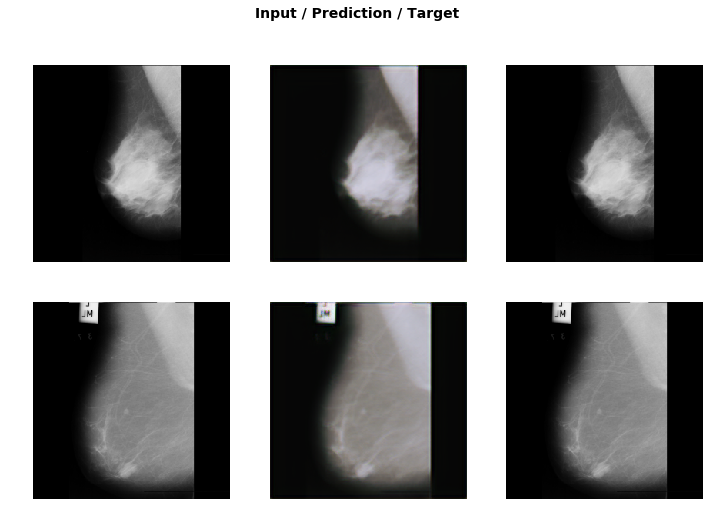

In [0]:
learn_gen.show_results(rows=2)


In [0]:
learn_gen.save('gen-pre2')


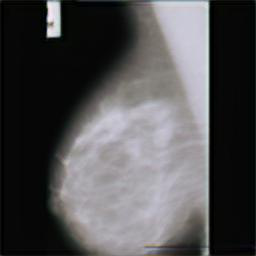

In [0]:
learn_gen.load('gen-pre2');
name_gen = 'image_gen'
path_gen = path/name_gen
# shutil.rmtree(path_gen)
path_gen.mkdir(exist_ok=True)
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1
save_preds(data_gen.fix_dl)
PIL.Image.open(path_gen.ls()[0])


In [0]:
learn_gen=None
gc.collect()


20

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:525: UserWarning: You are labelling your items with CategoryList.
Your train set contained the following unknown labels, the corresponding items have been discarded.
data
  if getattr(ds, 'warn', False): warn(ds.warn)


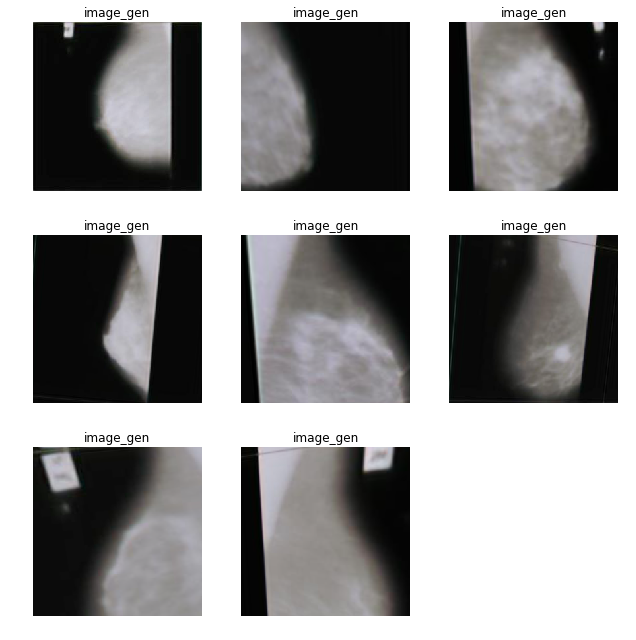

In [0]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)


In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)
learn_critic.fit_one_cycle(6, 1e-3)


epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.417229,0.000013,1.000000,00:08
1,0.203057,0.000000,1.000000,00:02
2,0.131230,0.000000,1.000000,00:02
3,0.095384,0.000000,1.000000,00:02
4,0.073928,0.000000,1.000000,00:02
5,0.059670,0.000000,1.000000,00:02


In [0]:
learn_critic.save('critic-pre2')


In [0]:
learn_crit=None
learn_gen=None
gc.collect()

15202

In [0]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)


/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:445: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")
/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:525: UserWarning: You are labelling your items with CategoryList.
Your train set contained the following unknown labels, the corresponding items have been discarded.
data
  if getattr(ds, 'warn', False): warn(ds.warn)


In [0]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')


In [0]:
learn_gen = create_gen_learner().load('gen-pre2')


In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))
lr = 1e-4


In [0]:
learn.fit(40,lr)


In [0]:
learn.save('gan-1c')
learn.data=get_data(16,192)
learn.fit(10,lr/2)

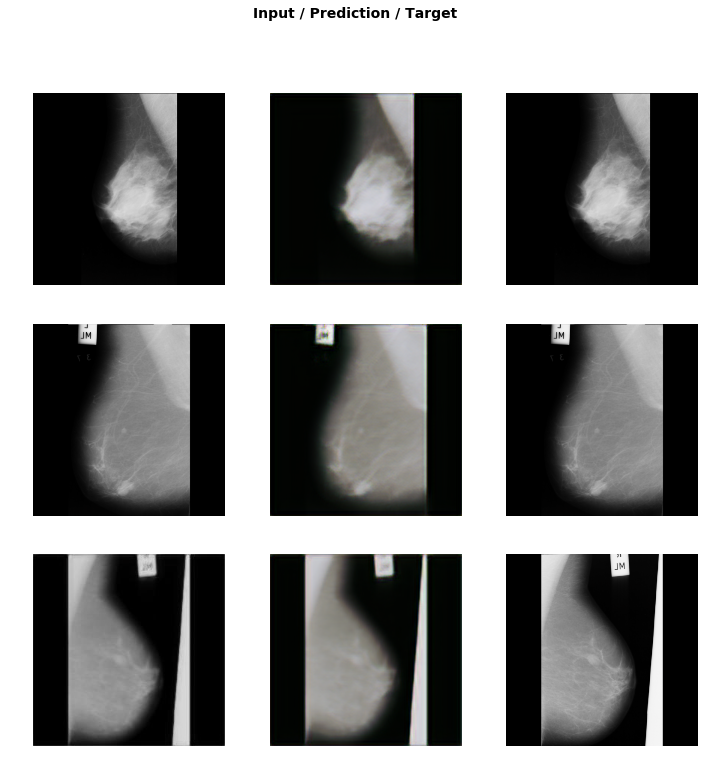

In [0]:
learn.show_results(rows=3)


In [0]:
learn.save('gan-1c')
